## Tom's work starts here.

### Gather dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import csv
import os
import scipy.stats as st
from scipy.stats import linregress

### Function for quickly calling a DataFrame

In [2]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

### Create DataFrame for CDC Data

In [3]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df.head()

,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


### Drop NaN and compile totals by county and race

In [4]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df.head()

,County,Race,Infections
0,ANOKA,African American,2864
1,ANOKA,Asian,1732
2,ANOKA,Caucasian,24501
3,ANOKA,Hispanic,746
4,ANOKA,Native American,73


### Create poverty DataFrame based on US Census

In [5]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)

# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df

,County,State,Poverty Total,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,Minnesota,1373,717,29,97,8,0,245,277,2020
83,ROSEAU,Minnesota,1133,971,6,67,11,0,28,50,2020
84,SHERBURNE,Minnesota,4953,2857,578,171,251,0,737,359,2020
85,STEELE,Minnesota,2887,1835,426,113,3,0,149,361,2020


In [6]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,11778,3697,327,953,0,1964,1551
1,BECKER,2296,17,709,45,0,381,140
2,BELTRAMI,3657,310,3056,39,0,734,371
3,BENTON,2605,333,19,73,0,205,122
4,BIG STONE,596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
82,RENVILLE,717,29,97,8,0,245,277
83,ROSEAU,971,6,67,11,0,28,50
84,SHERBURNE,2857,578,171,251,0,737,359
85,STEELE,1835,426,113,3,0,149,361


In [7]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df

,County,Race,Poverty
0,AITKIN,African American,13
1,AITKIN,Asian,0
2,AITKIN,Caucasian,1711
3,AITKIN,Hawaiian,0
4,AITKIN,Hispanic,45
...,...,...,...
604,YELLOW MEDICINE,Caucasian,722
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,53
607,YELLOW MEDICINE,Native American,30


### Create population DataFrame by county and race

In [9]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df.head()

,County,Population Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080
1,BECKER,34227,29290,146,1938,209,6,738,1900
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514
3,BENTON,40476,35979,1876,49,378,0,1086,1108
4,BIG STONE,4974,4787,3,3,0,0,102,79


In [10]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df.head()

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,283436,23534,1788,16082,86,12080,16769
1,BECKER,29290,146,1938,209,6,1900,738
2,BELTRAMI,33506,399,8920,295,36,2514,1114
3,BENTON,35979,1876,49,378,0,1108,1086
4,BIG STONE,4787,3,3,0,0,79,102


In [11]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df.head()

,County,Race,Population
0,AITKIN,African American,61
1,AITKIN,Asian,40
2,AITKIN,Caucasian,14831
3,AITKIN,Hawaiian,9
4,AITKIN,Hispanic,216


### Merge the datasets

In [12]:
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'])
merged_df.head()

,County,Race,Population,Poverty,Infections
0,ANOKA,African American,23534,3697,2864
1,ANOKA,Asian,16082,953,1732
2,ANOKA,Caucasian,283436,11778,24501
3,ANOKA,Hispanic,16769,1551,746
4,ANOKA,Native American,1788,327,73


In [13]:
# Edited merge_df for nan infections to be 0
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
merged_df["Infections"] = merged_df["Infections"].fillna(0)
merged_df

# Convert all numerical values in merged_df from strings to int
merged_df["Population"] = merged_df["Population"].astype(int)
merged_df["Poverty"] = merged_df["Poverty"].astype(int)
merged_df["Infections"] = merged_df["Infections"].astype(int)

# Calculate poverty and infection rates
poverty_rate = []
infection_rate = []

i = 0
while i < len(merged_df):
    if merged_df["Population"][i] == 0:
        poverty_rate.append(0)
        infection_rate.append(0)
    else: 
        poverty_rate.append(merged_df["Poverty"][i] / merged_df["Population"][i])
        infection_rate.append(merged_df["Infections"][i] / merged_df["Population"][i])
    i += 1
    
merged_df["Poverty Rate"] = poverty_rate
merged_df["Infection Rate"] = infection_rate

# merged_df[merged_df["County"] == "CROW WING"]    
merged_df.head()

,County,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,AITKIN,African American,61,13,0,0.213115,0.0
1,AITKIN,Asian,40,0,0,0.000000,0.0
2,AITKIN,Caucasian,14831,1711,0,0.115366,0.0
3,AITKIN,Hawaiian,9,0,0,0.000000,0.0
4,AITKIN,Hispanic,216,45,0,0.208333,0.0


In [14]:
# Convert all non-caucasian races to "non-caucasian"
#non_caucasian = ['African American', 'Hispanic', 'Asian', 'Native American', 'Hawaiian', 'Other']
merged_df['Two-Races']=["Non-Caucasian" if (x=="African American" or x=="Asian" or x=="Hispanic" or x=="Native American"\
    or x=="Hawaiian" or x=="Other") else "Caucasian" for x in merged_df['Race']]
merged_df.head()

,County,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate,Two-Races
0,AITKIN,African American,61,13,0,0.213115,0.0,Non-Caucasian
1,AITKIN,Asian,40,0,0,0.000000,0.0,Non-Caucasian
2,AITKIN,Caucasian,14831,1711,0,0.115366,0.0,Caucasian
3,AITKIN,Hawaiian,9,0,0,0.000000,0.0,Non-Caucasian
4,AITKIN,Hispanic,216,45,0,0.208333,0.0,Non-Caucasian


In [15]:
# Metro area counties
merged_df['Metro-Non']=["Metro" if (x=="RAMSEY" or x=="DAKOTA" or x=="HENNEPIN" or x=="ANOKA"\
    or x=="SCOTT" or x=="WASHINGTON" or x=="CARVER") else "Non_Metro" for x in merged_df['County']]
merged_df_metro = merged_df[['Metro-Non', 'County', 'Two-Races', 'Population', 'Poverty', 'Infections']]
merged_df_metro.head()

,Metro-Non,County,Two-Races,Population,Poverty,Infections
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0
2,Non_Metro,AITKIN,Caucasian,14831,1711,0
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0


In [16]:
race_df = merged_df_metro[['Two-Races', 'Population']].groupby(['Two-Races'])
race_df.sum().reset_index()

metro_df = merged_df_metro[['Metro-Non', 'Population']].groupby(['Metro-Non'])
metro_df.sum().reset_index()

,Metro-Non,Population
0,Metro,3090774
1,Non_Metro,2509392


In [17]:
two_races_df = merged_df[['County', 'Two-Races', 'Population', 'Poverty', 'Infections']]
two_races_df.head()

,County,Two-Races,Population,Poverty,Infections
0,AITKIN,Non-Caucasian,61,13,0
1,AITKIN,Non-Caucasian,40,0,0
2,AITKIN,Caucasian,14831,1711,0
3,AITKIN,Non-Caucasian,9,0,0
4,AITKIN,Non-Caucasian,216,45,0


In [ ]:
# pd.set_option('mode.chained_assignment', None)
# poverty_rate = []
# infection_rate = []

# i = 0
# while i < len(two_races_df):
#     if two_races_df["Population"][i] == 0:
#         poverty_rate.append(0)
#         infection_rate.append(0)
#     else: 
#         poverty_rate.append(two_races_df["Poverty"][i] / two_races_df["Population"][i])
#         infection_rate.append(two_races_df["Infections"][i] / two_races_df["Population"][i])
#     i += 1
    
# two_races_df["Poverty Rate"] = poverty_rate
# two_races_df["Infection Rate"] = infection_rate

In [ ]:
# caucasian = two_races_df.loc[two_races_df['Two-Races'] == 'Caucasian']

# # Population, poverty, and infection totals
# row_sum = two_races_df.iloc[:,2:5].sum()

# two_races_df.loc['Total'] = row_sum
# two_races_df.fillna('')
# two_races_df.loc['Total', 'County']=''
# two_races_df.loc['Total', 'Two-Races'] = ''
# two_races_df.loc['Total', 'Poverty Rate'] = ''
# two_races_df.loc['Total', 'Infection Rate'] = ''
# two_races_df

## Statistical Overview

In [18]:
#Mean and Median
mean_df = merged_df.groupby('Race').mean()
mean_df.reset_index()

,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,African American,4075.172414,1053.126437,419.160920,0.263118,0.023234
1,Asian,3139.080460,399.045977,238.988506,0.137476,0.010979
2,Caucasian,50833.218391,3045.620690,3776.333333,0.075060,0.044010
3,Hawaiian,21.896552,4.114943,0.000000,0.052836,0.000000
4,Hispanic,3536.494253,602.609195,117.988506,0.204458,0.010016
5,Native American,556.425287,189.965517,35.000000,0.310673,0.012460
6,Other,2207.436782,581.206897,63.206897,0.394056,0.006409


In [19]:
# Statistics by county
#lief's groupby
merged_county_gb = merged_df.groupby(["County"])

county_pop_stats = merged_county_gb["Population"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_stats = merged_county_gb["Poverty"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_stats = merged_county_gb["Infections"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_rate_stats = merged_county_gb["Poverty Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_rate_stats = merged_county_gb["Infection Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

#county_inf_rate_stats_ex = county_inf_rate_stats.loc[county_inf_rate_stats['County' == 'HENNEPIN']]
#county_inf_rate_stats_ex
print(county_pop_stats)
print(county_pov_rate_stats)
print(county_inf_stats)
print(county_pov_rate_stats)
print(county_inf_rate_stats)


                    max  min          mean   median           var  \
County                                                              
AITKIN            14831    9   2260.857143    216.0  3.074236e+07   
ANOKA            283436   86  50539.285714  16082.0  1.061654e+10   
BECKER            29290    6   4889.571429    738.0  1.164207e+08   
BELTRAMI          33506   36   6683.428571   1114.0  1.495583e+08   
BENTON            35979    0   5782.285714   1086.0  1.777527e+08   
...                 ...  ...           ...      ...           ...   
WATONWAN           7782    0   1557.571429     86.0  8.594244e+06   
WILKIN             5819    0    894.857143     56.0  4.719702e+06   
WINONA            46137    0   7249.142857   1003.0  2.943739e+08   
WRIGHT           125212    8  19483.857143   2360.0  2.175627e+09   
YELLOW MEDICINE    8725    0   1396.428571    229.0  1.046829e+07   

                           std           sem  
County                                        
AITKIN  

### Charting Race & Poverty

### Bar Charts on Race and Poverty

<AxesSubplot:title={'center':'The Number of People in Poverty in Minnesota'}, xlabel='Race', ylabel='Poverty'>

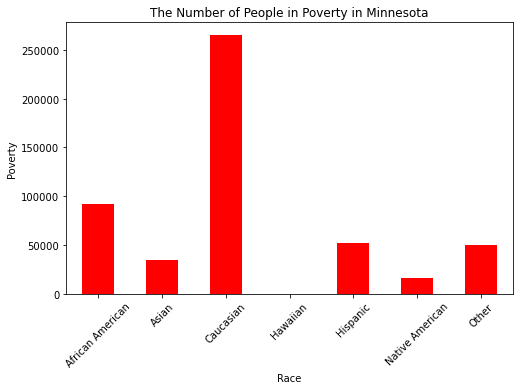

In [20]:
# Generate a bar plot showing the total population of race groups, poverty and analyzing the differences of each groups for the merged dataframe
bar_plot_data = merged_df.groupby(['Race']).sum()["Poverty"]
plt.title("The Number of People in Poverty in Minnesota")
plt.xlabel("Race")
plt.ylabel("Poverty")
bar_plot_data.plot.bar(figsize=(8,5),color=('red'), rot=45)

In [21]:
plot_df = merged_df.groupby(['Race']).sum()
plot_df

,Population,Poverty,Infections,Poverty Rate,Infection Rate
Race,,,,,
African American,354540,91622,36467,22.891273,2.021357
Asian,273100,34717,20792,11.960411,0.955200
Caucasian,4422490,264969,328541,6.530205,3.828903
Hawaiian,1905,358,0,4.596706,0.000000
Hispanic,307675,52427,10265,17.787846,0.871395
Native American,48409,16527,3045,27.028563,1.083980
Other,192047,50565,5499,34.282836,0.557564


In [22]:
max_pop = plot_df['Population'].max()
max_pop

4422490

Text(0, 0.5, 'Population (in millions)')

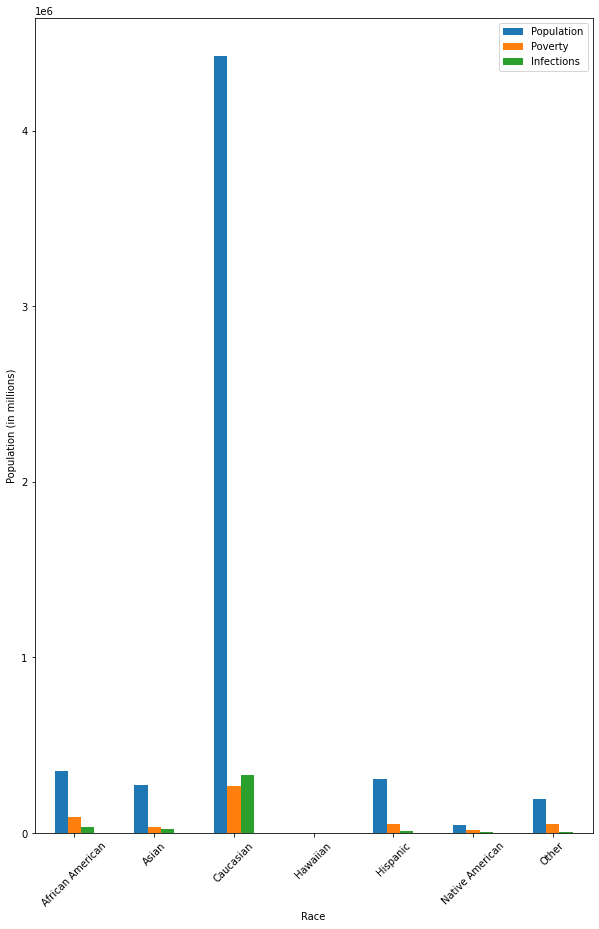

In [25]:
# Generate a bar chart to show the max population, poverty and infections of each race in MN
plot_df[['Population','Poverty','Infections']].plot.bar(figsize=(10,15), rot=45)
plt.xlabel("Race")
plt.ylabel("Population (in millions)")

Text(0, 0.5, 'Rate')

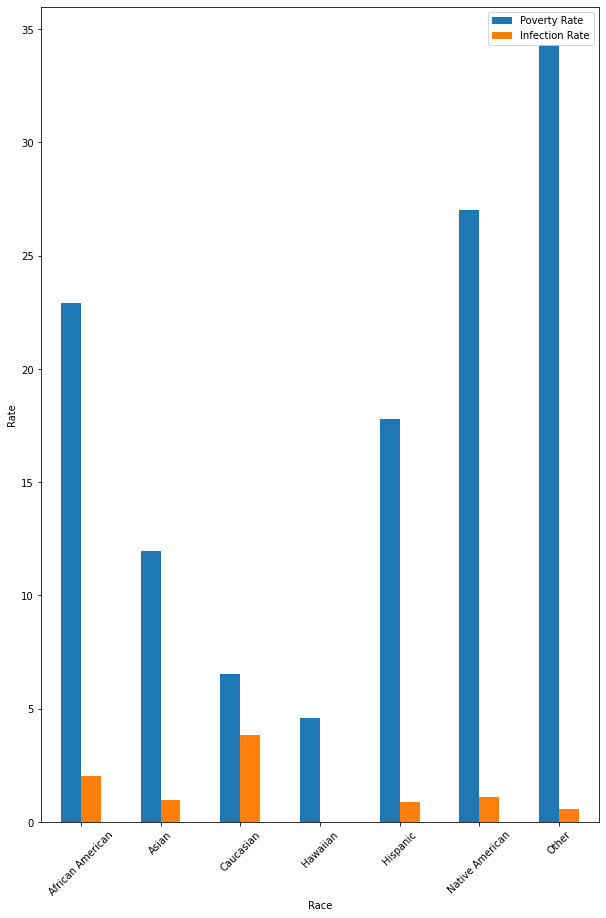

In [27]:
# Generate a 3 bar chart to show poverty rate and infection rate for each of the race in MN
plot_df[['Poverty Rate','Infection Rate']].plot.bar(figsize=(10,15), rot=45)
plt.xlabel("Race")
plt.ylabel("Rate")

### Boxplots Based on Race and Poverty

<AxesSubplot:title={'center':'Poverty Rate'}, xlabel='Race'>

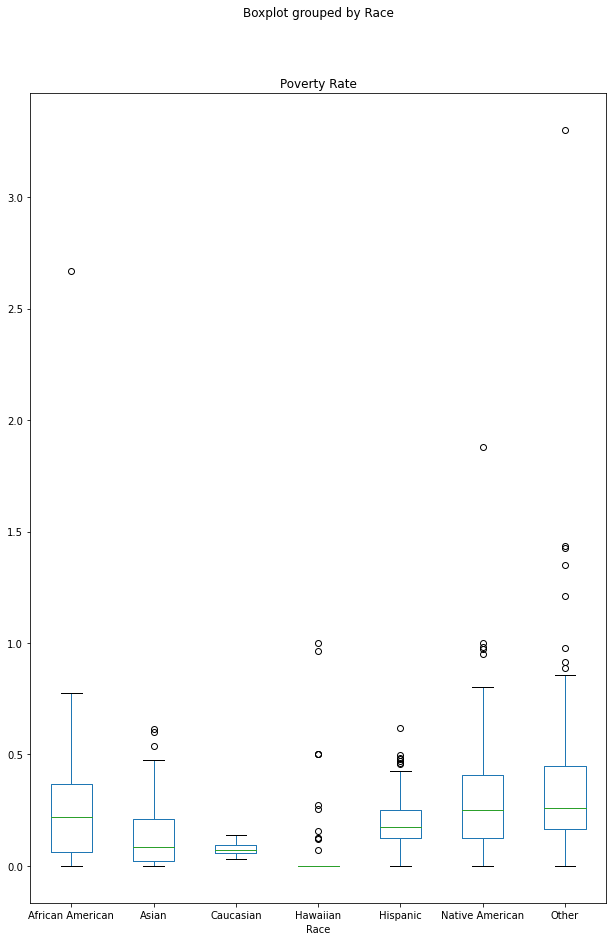

In [28]:
# Generate a bar plot showing the total population of races and poverty rate
merged_df.boxplot(by='Race', column=['Poverty Rate'], grid=False,figsize=(10, 15))

In [ ]:
# Generate a bar plot showing the total population of races and infections
merged_df.boxplot(by='Race', column=['Infections'], grid=False,figsize=(10, 15))

# Sung's work starts here

 ### keywords: Population in Minnesota (MN), Race, Poverty, Infection rate, Poverty rate
 ### Utilized data from CDC.gov and Population Census datasets.

## Number of Infections by Race and County

In [ ]:
# Drop NaNs and then sort by date chronologically
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
race_mn = cdc_df['Race'].unique()
race_mn = sorted(set(race_mn))
race_mn
cdc_df

## Number of Infections by Race and County
   ### a) Total infections for African American.

In [ ]:
#total sum of infections of African American.
cdc_infections_african_american_df = cdc_df.loc[  cdc_df['Race'] == race_mn[0]]
cdc_infections_african_american_df = cdc_infections_african_american_df.groupby(['County', 'Race'])
cdc_infections_african_american_sum_df = cdc_infections_african_american_df.sum()
cdc_infections_african_american_sum_df.head()

In [ ]:
cdc_infections_african_american_total = cdc_infections_african_american_sum_df['Infections'].sum()
cdc_infections_african_american_total

### b) Total infections for Asian.

In [ ]:
#total sum of infections of Asians
cdc_infections_asian_df = cdc_df.loc[  cdc_df['Race'] == race_mn[1]]
cdc_infections_asian_df = cdc_infections_asian_df.groupby(['County', 'Race'])
cdc_infections_asian_sum_df = cdc_infections_asian_df.sum()
cdc_infections_asian_sum_df.head()

In [ ]:
cdc_infections_asian_total = cdc_infections_asian_sum_df['Infections'].sum()
cdc_infections_asian_total

### c) Total infections for Caucasian American.

In [ ]:
cdc_infections_caucasian_df = cdc_df.loc[  cdc_df['Race'] == race_mn[2]]
cdc_infections_caucasian_df = cdc_infections_caucasian_df.groupby(['County', 'Race'])
cdc_infections_caucasian_sum_df = cdc_infections_caucasian_df.sum()
cdc_infections_caucasian_sum_df.head()

In [ ]:
cdc_infections_caucasian_total = cdc_infections_caucasian_sum_df['Infections'].sum()
cdc_infections_caucasian_total

### d) Total infections for Hispanic.

In [ ]:
#total sum of infections of asians in 2021
cdc_infections_hispanic_df = cdc_df.loc[  cdc_df['Race'] == race_mn[3]]
cdc_infections_hispanic_df = cdc_infections_hispanic_df.groupby(['County', 'Race'])
cdc_infections_hispanic_sum_df = cdc_infections_hispanic_df.sum()
cdc_infections_hispanic_sum_df.head()

In [ ]:
cdc_infections_hispanic_total = cdc_infections_hispanic_sum_df['Infections'].sum()
cdc_infections_hispanic_total

### e) Total infections for Native American.

In [ ]:
#total sum of infections of Native American in 2021
cdc_infections_native_american_df = cdc_df.loc[  cdc_df['Race'] == race_mn[4]]
cdc_infections_native_american_df = cdc_infections_native_american_df.groupby(['County', 'Race'])
cdc_infections_native_american_sum_df = cdc_infections_native_american_df.sum()
cdc_infections_native_american_sum_df.head()

In [ ]:
cdc_infections_native_american_total = cdc_infections_native_american_sum_df['Infections'].sum()
cdc_infections_native_american_total

### f) Total infections for other.

In [ ]:
#total sum of infections of other in 2021
cdc_infections_other_df = cdc_df.loc[  cdc_df['Race'] == race_mn[5]]
cdc_infections_other_df = cdc_infections_other_df.groupby(['County', 'Race'])
cdc_infections_other_sum_df = cdc_infections_other_df.sum()
cdc_infections_other_sum_df.head()

In [ ]:
cdc_infections_other_total = cdc_infections_other_sum_df['Infections'].sum()
cdc_infections_other_total

In [ ]:
#summary of number of infections by race
total_infection_byrace = [cdc_infections_african_american_total, cdc_infections_asian_total, 
                               cdc_infections_caucasian_total, cdc_infections_hispanic_total, 
                               cdc_infections_native_american_total, cdc_infections_other_total]
for (race, infection) in zip(race_mn, total_infection_byrace):
    print(f" {race}: {infection}")

In [ ]:
african_american_asian_combined_df = pd.merge(cdc_infections_african_american_sum_df, cdc_infections_asian_sum_df, on=['County'], how = "outer")
african_american_asian_caucasian_combined_df = pd.merge(african_american_asian_combined_df, cdc_infections_caucasian_sum_df, on=['County'], how = "outer")
african_american_asian_caucasian_hispanic_combined_df = pd.merge(african_american_asian_caucasian_combined_df, cdc_infections_hispanic_sum_df, on=['County'], how = "outer")
african_american_asian_caucasian_hispanic_native_american_combined_df = pd.merge(african_american_asian_caucasian_hispanic_combined_df, cdc_infections_native_american_sum_df, on=['County'], how = "outer")

In [ ]:
# Rename columns. FINAL summary table
comprehensive_df = pd.merge(african_american_asian_caucasian_hispanic_native_american_combined_df, cdc_infections_other_sum_df, on=['County'], how = "outer")
comprehensive_df.columns = ['African American Infections', 'Asian Infections', 'Caucasian American Infections', 'Hispanic Infections', 'Native American Infections', 'Other Infections']
# comprehensive_clean_df = comprehensive_df.fillna(0)
comprehensive_df.head()

In [ ]:
# re-introducing 'Population Total' in the population dataframe for my calculation for hypothesis testing.
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df.head()
mn_pop_df = mn_pop_df[['Population Total', 'County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df.head()

In [ ]:
#population by race infected with covid-19

mn_pop = mn_pop_df['Population Total']
mn_caucasian_pop = mn_pop_df['Caucasian']
mn_african_american_pop = mn_pop_df['African American']
mn_native_american_pop = mn_pop_df['Native American']
mn_asian_pop = mn_pop_df['Asian']
mn_hawaiian_pop = mn_pop_df['Hawaiian']
mn_hispanic_pop = mn_pop_df['Hispanic']
mn_other_pop = mn_pop_df['Other']

mn_pop_list = list(mn_pop)
mn_pop_list
mn_caucasian_list = list(mn_caucasian_pop)
mn_caucasian_list
mn_african_american_list = list(mn_african_american_pop)
mn_african_american_list
mn_native_american_list = list(mn_native_american_pop)
mn_native_american_list
mn_asian_list = list(mn_asian_pop)
mn_asian_list
mn_hawaiian_list = list(mn_hawaiian_pop)
mn_hawaiian_list
mn_hispanic_list = list(mn_hispanic_pop)
mn_hispanic_list
mn_other_list = list(mn_other_pop)
mn_other_list
print(type(mn_pop_list[0]))

#converting string to integer
# print([int(x) for x in mn_pop_list])
mn_pop_int_list = [int(x) for x in mn_pop_list]
mn_caucasian_int_list = [int(x) for x in mn_caucasian_list]
mn_african_american_int_list = [int(x) for x in mn_african_american_list]
mn_native_american_int_list = [int(x) for x in mn_native_american_list]
mn_asian_int_list = [int(x) for x in mn_asian_list]
mn_hawaiian_int_list = [int(x) for x in mn_hawaiian_list]
mn_hispanic_int_list = [int(x) for x in mn_hispanic_list]
mn_other_int_list = [int(x) for x in mn_other_list]


print(type(mn_pop_int_list[0]))

In [ ]:
#sum
sum_mn_pop = sum(mn_pop_int_list)
sum_mn_caucasian = sum(mn_caucasian_int_list)
sum_mn_african_american = sum(mn_african_american_int_list)
sum_mn_native_american = sum(mn_native_american_int_list)
sum_mn_asian = sum(mn_asian_int_list)
sum_mn_hawaiian = sum(mn_hawaiian_int_list)
sum_mn_hispanic = sum(mn_hispanic_int_list)
sum_mn_other = sum(mn_other_int_list)

#percent
percent_mn_caucasian = sum_mn_caucasian/sum_mn_pop*100
percent_mn_african_american = sum_mn_african_american/sum_mn_pop*100
percent_mn_native_american = sum_mn_native_american/sum_mn_pop*100
percent_mn_asian = sum_mn_asian/sum_mn_pop*100
percent_mn_hawaiian = sum_mn_hawaiian/sum_mn_pop*100
percent_mn_hispanic = sum_mn_hispanic/sum_mn_pop*100
percent_mn_other = sum_mn_other/sum_mn_pop*100

## Population in MN by race

In [ ]:
#summary of population by race
population_by_race_summary = [sum_mn_pop, sum_mn_caucasian, sum_mn_african_american, 
                              sum_mn_native_american, sum_mn_asian, sum_mn_hawaiian, 
                              sum_mn_hispanic, sum_mn_other]
MN_population = ['Population', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']
for (racepopulation, mnsum) in zip(MN_population, population_by_race_summary):
    print(f" {racepopulation}: {mnsum}")

## Population % in MN by race

In [ ]:
#summary of population by race
population_per_by_race_summary = [percent_mn_caucasian, percent_mn_african_american, percent_mn_native_american,
                              percent_mn_asian, percent_mn_hawaiian, percent_mn_hispanic, percent_mn_other]
race_in_MN = ['Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']
for (racepopulation, per) in zip(race_in_MN, population_per_by_race_summary):
    print(f" {racepopulation}: {per}")

In [ ]:
#infection rate African American
african_american_infection_percent = (cdc_infections_african_american_total / sum_mn_african_american ) *100
african_american_infection_percent

#infection rate Asian
asian_infection_percent = (cdc_infections_asian_total / sum_mn_asian ) *100
asian_infection_percent

#infection rate Caucasian
caucasian_infection_percent = (cdc_infections_caucasian_total / sum_mn_caucasian ) *100
caucasian_infection_percent

#infection rate hispanic
hispanic_infection_percent = (cdc_infections_hispanic_total / sum_mn_hispanic ) *100
hispanic_infection_percent

#infection rate native american
native_american_infection_percent = (cdc_infections_native_american_total / sum_mn_native_american ) *100
native_american_infection_percent


other_infection_percent = (cdc_infections_other_total / sum_mn_other ) *100
other_infection_percent


percentage_race_infections = [african_american_infection_percent, asian_infection_percent, 
                              caucasian_infection_percent, hispanic_infection_percent, native_american_infection_percent, other_infection_percent]



In [ ]:
sum_non_caucasian_population = sum_mn_african_american + sum_mn_native_american + sum_mn_asian + sum_mn_hawaiian + sum_mn_hispanic + sum_mn_other
sum_non_caucasian_population
non_caucasian_infection_rate = sum_non_caucasian_population / sum_mn_pop
non_caucasian_infection_rate
sum_non_caucasian_population_infection = cdc_infections_african_american_total + cdc_infections_asian_total +cdc_infections_hispanic_total + cdc_infections_native_american_total + cdc_infections_other_total
sum_non_caucasian_population_infection

non_caucaisan_infection_percent1 = sum_non_caucasian_population_infection / sum_non_caucasian_population
non_caucasian_infection_ratio = non_caucaisan_infection_percent1 / non_caucasian_infection_rate
non_caucasian_infection_ratio

In [ ]:
#rate corrected by population,% (non-whites)
african_american_infection_percent_corrected = african_american_infection_percent / percent_mn_african_american
african_american_infection_percent_corrected
asian_infection_percent_corrected = asian_infection_percent / percent_mn_asian
hispanic_infection_percent_corrected = hispanic_infection_percent / percent_mn_hispanic
native_american_infection_percent_corrected = native_american_infection_percent / percent_mn_native_american
other_infection_percent_corrected = other_infection_percent / percent_mn_other


#rate corrected by population,% (whites)
caucasian_infection_percent_corrected = caucasian_infection_percent / percent_mn_caucasian

## Summary table of the Infection rate, % (Number of infections / Total Census Population of Race) of different racial groups in Minnesota from March 2020 to April 2022 

In [ ]:
# Dataframe showing infection rate
race_percent_df = pd.DataFrame({'African American':[african_american_infection_percent],
                     'Asian':[asian_infection_percent],
                     'Caucasian American':[caucasian_infection_percent],
                     'Hispanic':[hispanic_infection_percent],
                     'Native American':[native_american_infection_percent],
                     'Other':[other_infection_percent] 
                               })

# Declare a list that is to be converted into a column
# Dataframe showing infection rate
State = ['Infection rate by race group']
race_percent_df['Minnesota'] = State
race_percent_df = race_percent_df.reindex(columns=['Minnesota', 'African American', 'Asian', 'Caucasian American', 'Hispanic',
       'Native American', 'Other'])
race_percent_df

In [ ]:
# Dataframe showing infection rate or ratio by group (corrected by % population)

race_percent_corrected_df = pd.DataFrame({'African American':[african_american_infection_percent_corrected],
                     'Asian':[asian_infection_percent_corrected],
                     'Caucasian American':[caucasian_infection_percent_corrected],
                     'Hispanic':[hispanic_infection_percent_corrected],
                     'Native American':[native_american_infection_percent_corrected],
                     'Other':[other_infection_percent_corrected] 
                               })

# Declare a list that is to be converted into a column
# Dataframe showing infection rate or ratio by group (corrected by % population)
State = ['Infection rate by race group']
race_percent_corrected_df['Minnesota'] = State
race_percent_corrected_df = race_percent_corrected_df.reindex(columns=['Minnesota', 'African American', 'Asian', 'Caucasian American', 'Hispanic',
       'Native American', 'Other'])
race_percent_corrected_df

## Infection rate, % of Caucasian and Non-Caucasian in Minnesota from March 2020 to April 2022
    a) Caucasian vs Non-caucasian

In [ ]:
# Dataframe showing infection rate

#Adding a column.
# sum of non-caucasian columns
# Create List of columns
non_caucasian_list= ['African American', 'Asian',
       'Hispanic', 'Native American', 'Other']

race_percent_df['Non-Caucasian American'] = (race_percent_df[non_caucasian_list].sum(axis=1)) / 5
race_percent_df
race_percent_df = race_percent_df[['Minnesota', 'Caucasian American', 'Non-Caucasian American' ]]
race_percent_df

## Infection ratio (Infection rate / % population of race) of Caucasian and Non-Caucasian in Minnesota

In [ ]:
# Dataframe showing infection rate or ratio by group (corrected by % population)

#Adding a column.
# sum of non-caucasian columns
# Create List of columns
non_caucasian_list= ['African American', 'Asian',
       'Hispanic', 'Native American', 'Other']

race_percent_corrected_df['Non-Caucasian American'] = non_caucasian_infection_ratio
race_percent_corrected_df
race_percent_summary_df = race_percent_corrected_df[['Minnesota', 'Caucasian American', 'Non-Caucasian American' ]]
race_percent_summary_df

## Hypothesis Test #1
### $H_{0}$: Is the mean of the covid infection ratio of caucasian group equal to the mean of that of non-caucasian group?

In [ ]:
# Select column of interests and merge.
mn_pop_race_df = mn_pop_df[['County', 'African American', 'Asian', 'Caucasian', 'Native American', 'Hispanic', 'Other']]
cdc_census_combined_df = pd.merge(comprehensive_df, mn_pop_race_df, on=['County'], how = "outer")
cdc_census_clean_combined_df = cdc_census_combined_df.fillna(0)
cdc_census_clean_combined_df

In [ ]:
#converting all the rows to integer
column_list = ['African American Infections', 'Asian Infections',
       'Caucasian American Infections', 'Hispanic Infections',
       'Native American Infections', 'Other Infections', 'African American',
       'Asian', 'Caucasian', 'Native American', 'Hispanic', 'Other']

for column in column_list:
    cdc_census_clean_combined_df[column] = cdc_census_clean_combined_df[column].astype(int)

In [ ]:
# african american population by county DATAFRAME
cdc_census_clean_combined_african_american_df = cdc_census_clean_combined_df['African American']
cdc_census_clean_combined_african_american_df


In [ ]:
# Total racial Population by county DATAFRAME
cdc_census_clean_combined_asian_df = cdc_census_clean_combined_df['Asian']
cdc_census_clean_combined_caucasian_df = cdc_census_clean_combined_df['Caucasian']
cdc_census_clean_combined_native_american_df = cdc_census_clean_combined_df['Native American']
cdc_census_clean_combined_hispanic_df = cdc_census_clean_combined_df['Hispanic']
cdc_census_clean_combined_other_df = cdc_census_clean_combined_df['Other']

#total caucasian population by county DATAFRAME
cdc_census_clean_combined_caucasian_df

In [ ]:
# total population by county
cdc_census_clean_combined_sum_df = (cdc_census_clean_combined_african_american_df + cdc_census_clean_combined_caucasian_df + cdc_census_clean_combined_asian_df + cdc_census_clean_combined_native_american_df + cdc_census_clean_combined_hispanic_df + cdc_census_clean_combined_other_df)
cdc_census_clean_combined_sum_df

In [ ]:
# total population by county for non-caucasian group
cdc_census_clean_combined_sum_non_caucasian_df = (cdc_census_clean_combined_african_american_df + cdc_census_clean_combined_asian_df + cdc_census_clean_combined_native_american_df + cdc_census_clean_combined_hispanic_df + cdc_census_clean_combined_other_df)
cdc_census_clean_combined_sum_non_caucasian_df

In [ ]:
# number of infections by county non-caucasian group DATAFRAME
african_american_infection_df = cdc_census_clean_combined_df['African American Infections']
asian_infection_df = cdc_census_clean_combined_df['Asian Infections']
native_american_infection_df = cdc_census_clean_combined_df[ 'Native American Infections']
hispanic_infection_df = cdc_census_clean_combined_df['Hispanic Infections']
other_infection_df = cdc_census_clean_combined_df['Other Infections']

# number of infections by county caucasian group
caucasian_infection_df = cdc_census_clean_combined_df['Caucasian American Infections']
caucasian_infection_df

In [ ]:
#SUM OF number of infections NON-CACUASIAN DATAFRAME
sum_non_caucasian_infection_df = african_american_infection_df + asian_infection_df + native_american_infection_df + hispanic_infection_df + other_infection_df
sum_non_caucasian_infection_df

In [ ]:
# Population racial % by county
#non-caucasian group
county_asian_pop_percent = cdc_census_clean_combined_asian_df / cdc_census_clean_combined_sum_df
county_african_american_pop_percent = cdc_census_clean_combined_african_american_df / cdc_census_clean_combined_sum_df
county_native_american_pop_percent = cdc_census_clean_combined_native_american_df / cdc_census_clean_combined_sum_df
county_hispanic_pop_percent = cdc_census_clean_combined_hispanic_df / cdc_census_clean_combined_sum_df
county_other_pop_percent = cdc_census_clean_combined_asian_df / cdc_census_clean_combined_sum_df

#SUM OF NON-CACUASIAN DATAFRAME
sum_non_caucasian_pop_percent_df = county_asian_pop_percent + county_african_american_pop_percent + county_native_american_pop_percent + county_hispanic_pop_percent + county_other_pop_percent


# caucasian group
county_caucasian_pop_percent = cdc_census_clean_combined_caucasian_df / cdc_census_clean_combined_sum_df
county_caucasian_pop_percent

In [ ]:
# infection rate calculation non-caucasian group
non_caucasian_infection_rate_corrected_df = (sum_non_caucasian_infection_df / cdc_census_clean_combined_sum_df) / sum_non_caucasian_pop_percent_df

# infection rate calculation african american group
african_american_infection_rate_corrected_df = (african_american_infection_df / cdc_census_clean_combined_sum_df) / county_african_american_pop_percent
asian_infection_rate_corrected_df = (asian_infection_df / cdc_census_clean_combined_sum_df) / county_asian_pop_percent
native_american_infection_rate_corrected_df = (native_american_infection_df / cdc_census_clean_combined_sum_df) / county_native_american_pop_percent
hispanic_infection_rate_corrected_df = (hispanic_infection_df / cdc_census_clean_combined_sum_df) / county_hispanic_pop_percent
other_infection_rate_corrected_df = (other_infection_df / cdc_census_clean_combined_sum_df) / county_other_pop_percent



# number of infections by county caucasian group
caucasian_infection_rate_corrected_df = (caucasian_infection_df / cdc_census_clean_combined_sum_df) / county_caucasian_pop_percent
caucasian_infection_rate_corrected_df

## Summary table of infection ratio (Infection rate / % population of race) of caucasian and non-caucasian groups by County

In [ ]:
#filter to just show County column
cdc_census_combined_summary_df = cdc_census_clean_combined_df[['County']]
cdc_census_combined_summary_df


cdc_census_combined_summary_df[  'Non-Caucasian infection ratio'  ] = non_caucasian_infection_rate_corrected_df
cdc_census_combined_summary_df[  'Caucasian infection ratio'  ] = caucasian_infection_rate_corrected_df
cdc_census_combined_summary_df

In [ ]:
# Calculate the mean for infection rate of non-caucasian group
non_caucasian_infection_rate_corrected = cdc_census_combined_summary_df['Non-Caucasian infection ratio'].fillna(0)
non_caucasian_infection_rate_corrected.mean()
# non_caucasian_infection_rate = cdc_census_combined_summary_df['Non-Caucasian infection rate'].to_numpy()
# np.where(non_caucasian_infection_rate != np.nan)

In [ ]:
# Calculate the mean for infection rate of caucasian group
caucasian_infection_rate_corrected = cdc_census_combined_summary_df['Caucasian infection ratio']
caucasian_infection_rate_corrected.mean()

In [ ]:
# Calculate Independent (Two Sample) t-test
st.ttest_ind(non_caucasian_infection_rate_corrected, caucasian_infection_rate_corrected, equal_var=False)

# nan_policy="omit"

In [ ]:
print ("we safely reject the null hypothesis as the p-value is significantly lower than 0.05.")
print("Mean of the covid infection rates of caucasian group and non-caucasian group is not equal.")
print("Certainly higher covid infection rate was seen with non-caucasian communities.")

## Hypothesis Test #2
### ANOVA test
### $H_{0}$: Is the mean of the covid infection ratio of each race group equal across the racial groups?

In [ ]:
#dataframe showing infection rate by group (corrected by % population)

county_list = ['ANOKA', 'BELTRAMI', 'BENTON', 'BLUE EARTH', 'CARLTON', 'CARVER',
       'CHISAGO', 'CLAY', 'DAKOTA', 'GOODHUE', 'HENNEPIN', 'KANDIYOHI',
       'LYON', 'MOWER', 'NICOLLET', 'NOBLES', 'OLMSTED', 'OTTER TAIL',
       'PINE', 'POLK', 'RAMSEY', 'RICE', 'SCOTT', 'SHERBURNE',
       'ST. LOUIS', 'STEARNS', 'STEELE', 'WASHINGTON', 'WINONA', 'WRIGHT',
       'FREEBORN', 'ISANTI', 'BECKER', 'BROWN', 'CASS', 'CROW WING',
       'DODGE', 'DOUGLAS', 'FILLMORE', 'HUBBARD', 'ITASCA', 'LE SUEUR',
       'MCLEOD', 'MEEKER', 'MILLE LACS', 'MORRISON', 'TODD', 'WABASHA',
       'BIG STONE', 'CHIPPEWA', 'WATONWAN', 'WADENA', 'CLEARWATER',
       'COOK', 'COTTONWOOD', 'FARIBAULT', 'GRANT', 'HOUSTON', 'KANABEC',
       'KOOCHICHING', 'LAC QUI PARLE', 'LAKE OF THE WOODS', 'MARSHALL',
       'MARTIN', 'MURRAY', 'NORMAN', 'PENNINGTON', 'POPE', 'RED LAKE',
       'REDWOOD', 'ROCK', 'SIBLEY', 'STEVENS', 'SWIFT', 'TRAVERSE',
       'WASECA', 'WILKIN', 'YELLOW MEDICINE', 'AITKIN', 'JACKSON',
       'KITTSON', 'LAKE', 'LINCOLN', 'MAHNOMEN', 'PIPESTONE', 'RENVILLE',
       'ROSEAU']

cdc_census_combined_allrace_summary_df = pd.DataFrame({'County': county_list,
                     'African American': african_american_infection_rate_corrected_df,
                     'Asian': asian_infection_rate_corrected_df,
                     'Caucasian American': caucasian_infection_rate_corrected_df,
                     'Hispanic': hispanic_infection_rate_corrected_df,
                     'Native American': native_american_infection_rate_corrected_df,
                     'Other': other_infection_rate_corrected_df 
                               })

cdc_census_combined_allrace_summary_df

In [ ]:
#declare groups
group0 = african_american_infection_rate_corrected_df.fillna(0)
group1 = asian_infection_rate_corrected_df.fillna(0)
group2 = caucasian_infection_rate_corrected_df.fillna(0)
group3 = hispanic_infection_rate_corrected_df.fillna(0)
group4 = native_american_infection_rate_corrected_df.fillna(0)
group5 = other_infection_rate_corrected_df.fillna(0)

# group1 = asian_infection_rate_corrected_df.fillna(0).to_numpy()

In [ ]:
#ANOVA test
# Perform the ANOVA
st.f_oneway(group0, group1, group2, group3, group4, group5)

In [ ]:
#ANOVA test
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

In [ ]:
#ANOVA test
# Perform the ANOVA
st.f_oneway(group0, group2)

In [ ]:
print ("we safely reject the null hypothesis as the p-value is significantly lower than 0.05.")
print("mean of the covid infection rates are not equal across the different racial groups.")

## Hypothesis Test #3
### Poverty rate independent t-test
### $H_{0}$: Are cities with higher in poverty impacted by covid-19 (mean) the same rate as the cities with lower in poverty (mean)

In [ ]:
# Metro area counties
merged_df['Metro-Non']=["Metro" if (x=="RAMSEY" or x=="DAKOTA" or x=="HENNEPIN" or x=="ANOKA"\
    or x=="SCOTT" or x=="WASHINGTON" or x=="CARVER") else "Non_Metro" for x in merged_df['County']]
merged_df_metro = merged_df[['Metro-Non', 'County', 'Two-Races', 'Population', 'Poverty', 'Infections', 'Poverty Rate', 'Infection Rate']]
merged_df_metro.head(15)

In [ ]:
merged_df_metro.head(10)

In [ ]:
infection_poverty_rate_df = merged_df_metro['Poverty Rate'] * merged_df_metro['Infection Rate']
infection_poverty_rate_df.head(10)

In [ ]:
#Adding a column.
# Create List of columns
merged_df_metro['Infection poverty rate'] = infection_poverty_rate_df
merged_df_metro.head(15)


In [ ]:
merged_df_metro_group = merged_df_metro.groupby(['Metro-Non', 'Two-Races'])
merged_df_metro_group = merged_df_metro_group.head()
merged_df_metro_group

In [ ]:
merged_df_metro_group_non_metro = merged_df_metro_group.loc[  merged_df_metro_group['Metro-Non'] == 'Non_Metro']
merged_df_metro_group_non_metro = merged_df_metro_group_non_metro[['Metro-Non', 'Infection poverty rate']]
merged_df_metro_group_non_metro

In [ ]:
merged_df_metro_group_metro = merged_df_metro_group.loc[  merged_df_metro_group['Metro-Non'] == 'Metro']
merged_df_metro_group_metro = merged_df_metro_group_metro[['Metro-Non', 'Infection poverty rate']]
merged_df_metro_group_metro

In [ ]:
# Calculate the mean for infection rate*poverty rate in metro
metro_infection_poverty_rate = merged_df_metro_group_metro['Infection poverty rate'].fillna(0)
metro_infection_poverty_rate.mean()
# non_caucasian_infection_rate = cdc_census_combined_summary_df['Non-Caucasian infection rate'].to_numpy()
# np.where(non_caucasian_infection_rate != np.nan)

In [ ]:
# Calculate the mean for infection rate*poverty rate in metro
non_metro_infection_poverty_rate = merged_df_metro_group_non_metro['Infection poverty rate'].fillna(0)
non_metro_infection_poverty_rate.mean()

In [ ]:
# Calculate Independent (Two Sample) t-test
st.ttest_ind(metro_infection_poverty_rate, non_metro_infection_poverty_rate, equal_var=False)

In [ ]:
print("We fail to reject the null hypothesis since p-value is higher than 0.05")
print("Cities with high poverty rate is certainly more impacted by Covid-19 infection rate.")